<img
    style="border-radius: 0.5em;"
    src="https://ucfai.org/groups/projects/fa19/titanic/banner.png">

<div class="col-12">
    <h1> Understanding the Titanic Disaster </h1>
    <hr>
</div>

<div style="line-height: 2em;">
    <p>by: 
        <a href="https://ucfai.org/authors/ahkerrigan">@ahkerrigan</a> on Sep 26, 2019</p>
</div>

In [ ]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input")
if (DATA_DIR / "ucfai-projects-fa19-titanic").exists():
    DATA_DIR /= "ucfai-projects-fa19-titanic"
elif DATA_DIR.exists():
    # no-op to keep the proper data path for Kaggle
    pass
else:
    # You'll need to download the data from Kaggle and place it in the `data/`
    #   directory beside this notebook.
    # The data should be here: https://kaggle.com/c/ucfai-projects-fa19-titanic/data
    DATA_DIR = Path("data")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from scipy import stats

sns.set(style='white', context='notebook', palette='deep')

In [2]:
train = pd.read_csv(DATA_DIR / "titanic/train.csv")
test = pd.read_csv(DATA_DIR / "titanic/test.csv")
IDtest = test["PassengerId"]

In [3]:
## In order to make changes to all data, we need to combine train and test for the time being
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# When it comes to cleaning data, what is the very first thing you should do?
# Always manage your missing values. 

# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

# The reason why there is a significant number of null values in survived is only because we combiend the train and the test, and obviously we don't have the solutions for the test

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [5]:
# If we want to check what just the train looks like, we still have it in memory

train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [7]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

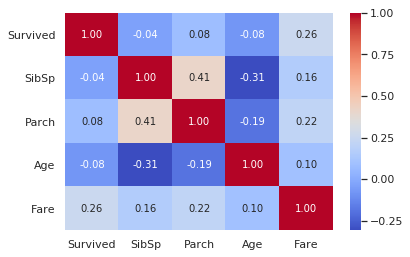

In [8]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [9]:
# Using a heatmap, we can check to see how our numerical values correlate with each other. As you can see, the only numerical value that seemst o really correlate with 
# survival is Fare. That's not to say that the others are useless, but intuitively you can imagine bigger fair = rich = surivived

In [10]:
# What definately is possible is that the other features have subpopulations that have actual correlation. That is to say``````````````````````

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


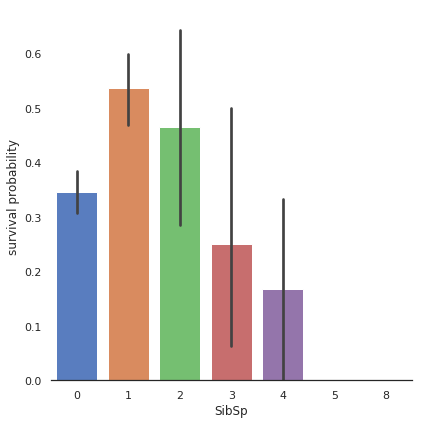

In [11]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [12]:
# What does thisd tell us about number of siblings?
# It tells us that while 0-2 siblings have a fairly average chance of survival, 3-4 have a dramatically smaller chance.
# This means that while sibling count isn't good by itself, knowing whether they have 3-4 is important

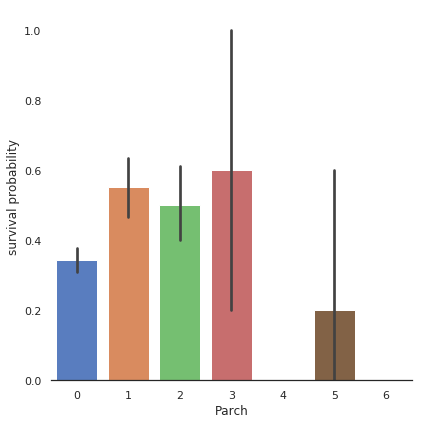

In [13]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [14]:
# What this tells us is that smaller families (1-2) have better chance of survival than people without families, or people wtih large families
# Why am I not saying that families of 3 have the best chance of surivial?
# While sure, the average seems marginally higher, the uncertainty is much greater around families of 3, meaning the values are more spread out.
# Families of 1-2 are much more certain to have more than 50% chance of survival.

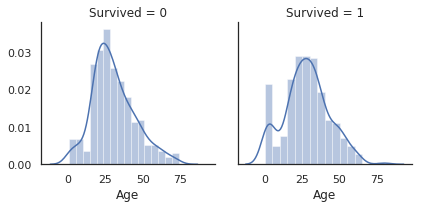

In [15]:
# Now, lets take a look at a Facet graph of Age
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

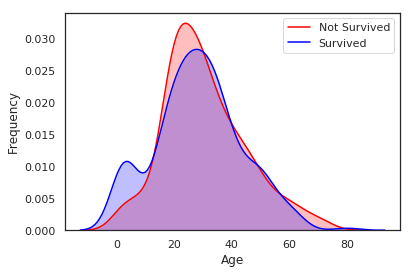

In [16]:
# What does this tell us
# Before in our heatmap, we noted that Age does not seem correlated with survival, but this graph tells a different story. 
# The distribution seems somewhat normal, except for the unusual jump in survivability of infants
# This means it might be valauble to classify passenger into age groups, rather than leave their age
# let's try superimposing these to get a clearer picture

# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [17]:
# Let's move onto Fare
dataset["Fare"].isnull().sum()

1

In [18]:
# Theres only a single missing value of fare, what should we do with it?
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

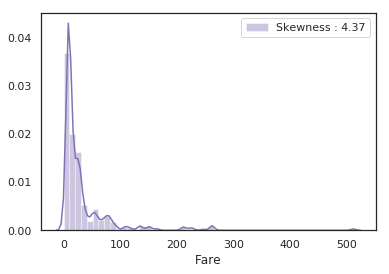

In [19]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [20]:
# Oof, this is extremly skewed. This means that our model is going to massively overweight values on the right end. Therefore, we should probobly transform it into a log function
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)


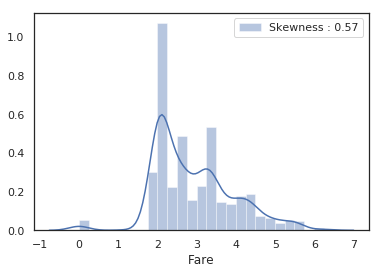

In [21]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")


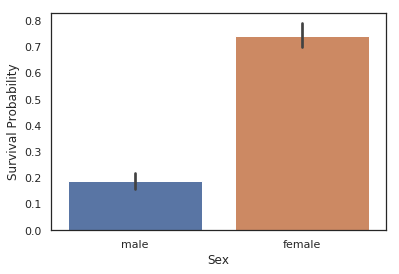

In [22]:
# That looks much, much better right?
# Let's move onto sex
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [23]:
# Oh wow, men only have about a 20% chance of survival, while women have 70%
# You could actually stop everything right now and just predict survival based on gender and get ~75% accuracy wiht these numbers

In [24]:
train[["Sex","Survived"]].groupby('Sex').mean()

Survived
Sex             
female  0.742038
male    0.188908

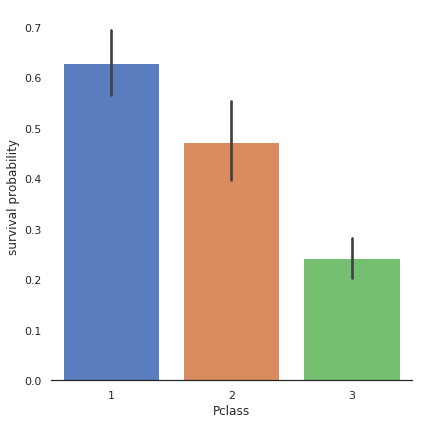

In [25]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

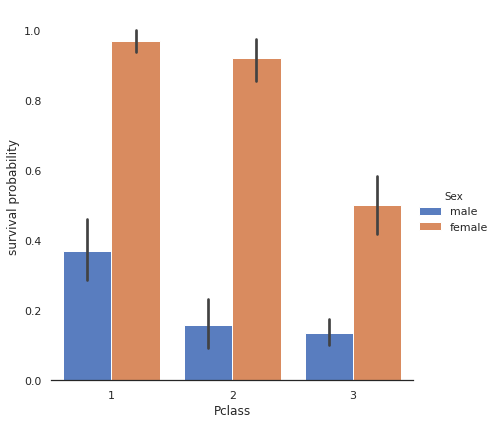

In [26]:
# As you would expect, chance of survival is pretty much directly correlated with class
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

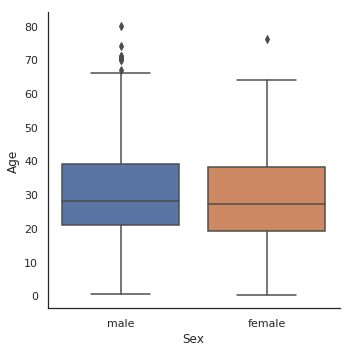

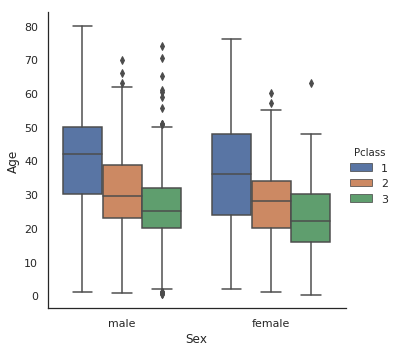

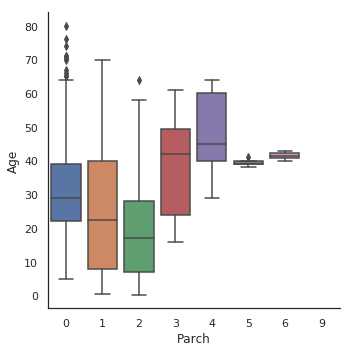

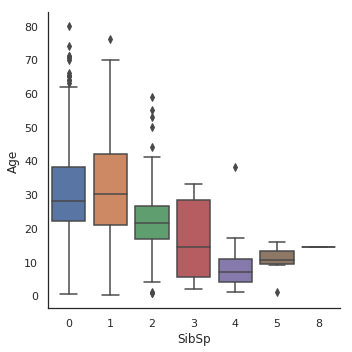

In [27]:
# As we saw earlier with our exploration of Age, there is clearly some information hidden within
# However there are 300 values missing. This is way too many to simply replace with the mean (because 300 missing is enough to shift the mean to a false value)
# The solution: Let's see if there is some other variable that correlates with Age, and use that to predict what the missing age might be
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

In [28]:
# What can we conclude from these graphs?

In [29]:
# The distribution of age seems to be the same across male and femlae,  the higher the class of passenger, the older they are
# Parch (parents/children) seem to be postively correlated wtih age, while sibling count engativly correlated. T
# That is to say, older passengers tend to have more children/parents, while younger passengers have more siblings

In [30]:
# Let's go ahead and convert sex to a numerical value since we missed it
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

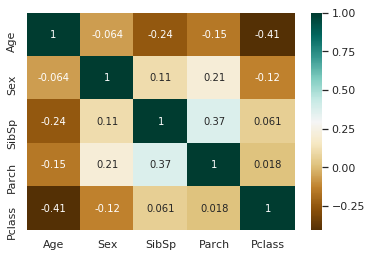

In [31]:
# Let's look directly at the correlation between numerical features
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)


In [32]:
# This is a good example of our visual intuition being wrong. We were correct that Age and Sex have nothing to do with each other
# But parent/childen is actually negativly correlated with age, as is class and sibling count
# Heres how we're going to do it. For every missing Age value, we are going to find rows with the same Sibling, parch, and class values as that row with missing age, and average those ages

In [33]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


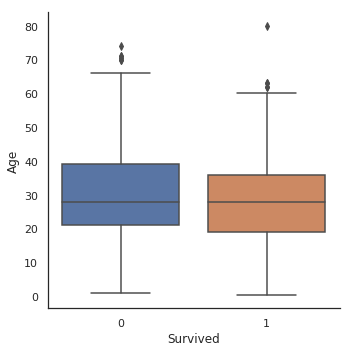

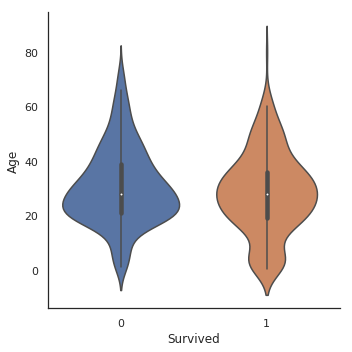

In [34]:
# Let's see how things changed
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

In [35]:
# So theres still not correlation between ages and survival, except for that little blip at the buttom of the survived violen

In [36]:
# Now it's time for the best part: Feature engineering
# Quesion: Should we keep the name of passengers? How could the name be useful?

In [37]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

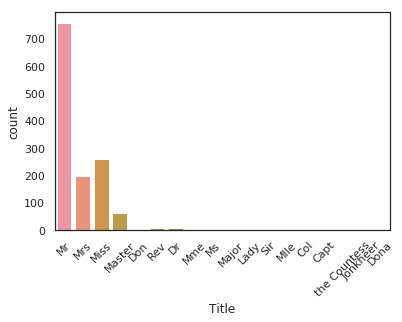

In [38]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [39]:
# So it would be a waste of time to worry about titles that only appear once or twice, so let's just change them to "rare"
# Then, let's map each title to 
# Convert to categorical values for title Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

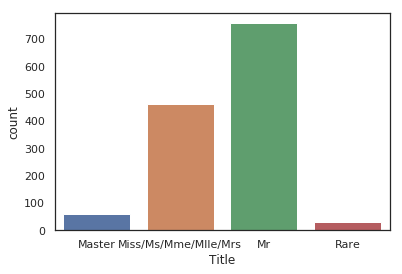

In [40]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

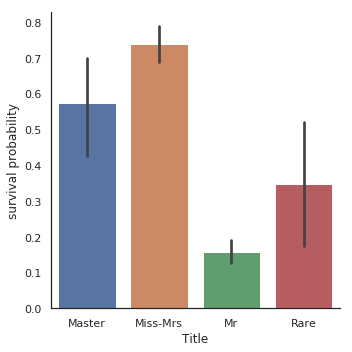

In [41]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [42]:
# Well, we already know how important sex was to survival, but now "master" is revealing the importance of children as well
# As we know "Women and children first"
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

# If you recall, the only useful information from Age was that children had a slight advantage from
# survival. However, most Ages were actually missing. There were no missing titles, so we're instead
# going to rely on the existing of the "master" title to figure out who is a child.
# Did we waste a ton of time cleaning up the Ages? Not really, a lot of the time when working on data
# you find that previous approaches were not as good as you originally expected
dataset.drop(labels = ["Age"], axis = 1, inplace = True)

In [43]:
dataset.head()

Cabin Embarked      Fare  Parch  PassengerId  Pclass  Sex  SibSp  Survived  \
0   NaN        S  1.981001      0            1       3    0      1       0.0   
1   C85        C  4.266662      0            2       1    1      1       1.0   
2   NaN        S  2.070022      0            3       3    1      0       1.0   
3  C123        S  3.972177      0            4       1    1      1       1.0   
4   NaN        S  2.085672      0            5       3    0      0       0.0   

             Ticket  Title  
0         A/5 21171      2  
1          PC 17599      1  
2  STON/O2. 3101282      1  
3            113803      1  
4            373450      2

In [44]:
# Let's go over to family size again, since we talked about that a lot
# Let's examine size of family, including the passenger themselves
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

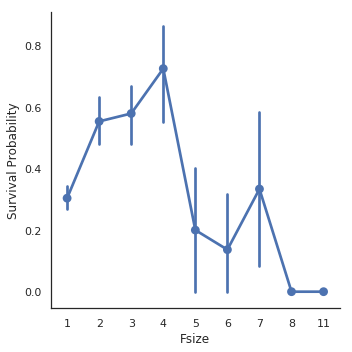

In [45]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

In [46]:
# Lets break these into 4 categories
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

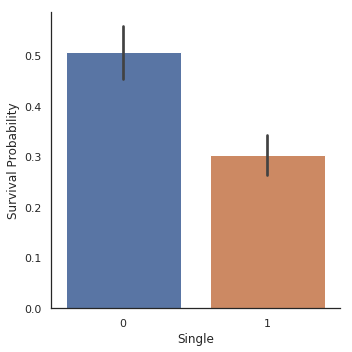

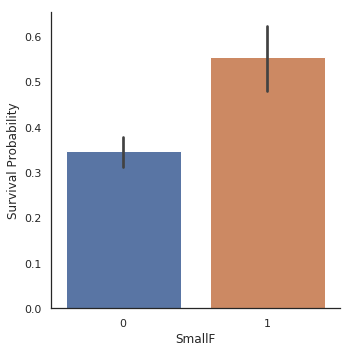

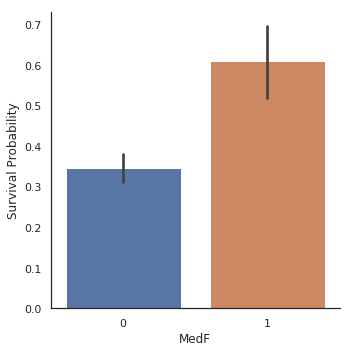

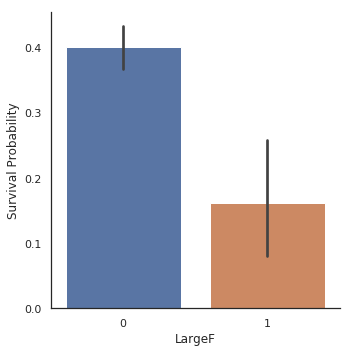

In [47]:
# We've essentially turned family size into a binary value, since theres no clear smooth correlation`
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [48]:
# We're gong to convert Title and embarked to binary values (a different column for each possible title/embark point)
# dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [49]:
dataset.head()

Cabin      Fare  Parch  PassengerId  Pclass  Sex  SibSp  Survived  \
0   NaN  1.981001      0            1       3    0      1       0.0   
1   C85  4.266662      0            2       1    1      1       1.0   
2   NaN  2.070022      0            3       3    1      0       1.0   
3  C123  3.972177      0            4       1    1      1       1.0   
4   NaN  2.085672      0            5       3    0      0       0.0   

             Ticket  Title  Fsize  Single  SmallF  MedF  LargeF  Em_C  Em_Q  \
0         A/5 21171      2      2       0       1     0       0     0     0   
1          PC 17599      1      2       0       1     0       0     1     0   
2  STON/O2. 3101282      1      1       1       0     0       0     0     0   
3            113803      1      2       0       1     0       0     0     0   
4            373450      2      1       1       0     0       0     0     0   

   Em_S  
0     1  
1     0  
2     1  
3     1  
4     1

In [50]:
# What about cabin?
dataset["Cabin"].isnull().sum()


1014

In [51]:
# In an old version of this, we tried this with Cabin, and in fact using it drops our score my 2 percent. Try running it and see what happens
# Can you explain why this is actually suboptimal?
"""

# That is...a lot of missing values```````````````````````````````````````````````
# Let's just replace missing values with an X, indicating no cabin listed
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])
"""

'\n\n# That is...a lot of missing values```````````````````````````````````````````````\n# Let\'s just replace missing values with an X, indicating no cabin listed\ndataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else \'X\' for i in dataset[\'Cabin\'] ])\n'

In [52]:
#g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])


In [53]:
#g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
#g = g.set_ylabels("Survival Probability")

In [54]:
#dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")


In [55]:
#
#dataset.head()


In [56]:
# Ticket may have some information, buts its very likely to be similar to fair, so lets just drop it. Let's drop passengerID as well
dataset.drop(labels = ["PassengerId", "Ticket", "Cabin"], axis = 1, inplace = True)

In [57]:
# Alright, time for some machine learning!
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
# We need a cross-validator for our hyperparameter searcher
kfold = StratifiedKFold(n_splits=10)

In [60]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.1min finished


0.8361391694725028

In [61]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   29.7s finished


0.835016835016835

In [62]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   30.6s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8249158249158249

In [63]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 620 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    4.3s finished


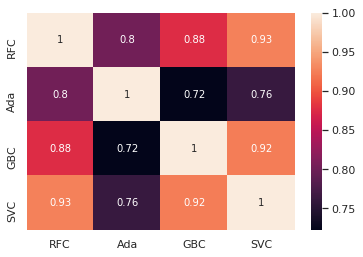

In [64]:
# Let's see how they all do
# Note: I chose these 4 classifiers for you because I already know they do well for this problem
# As an excercise, look into more than 10 classifiers and look up how to rank their cross-validation score
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [65]:
# The final step: We will have these 4 models vote on each possible prediction
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)


votingC = votingC.fit(X_train, Y_train)

In [66]:
# Finally, let's send our submission to a CSV
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("TitanicSubmission.csv",index=False)